Team Gordon

Student Name	Student Number
 Alisha Sahota	20497348
 Anthony Ramelo	20499391
 Chris Wu	10182394
 Elizabeth Zhang	20161231
 Emily Zhao	10096273
 Sam Hossain	20466500


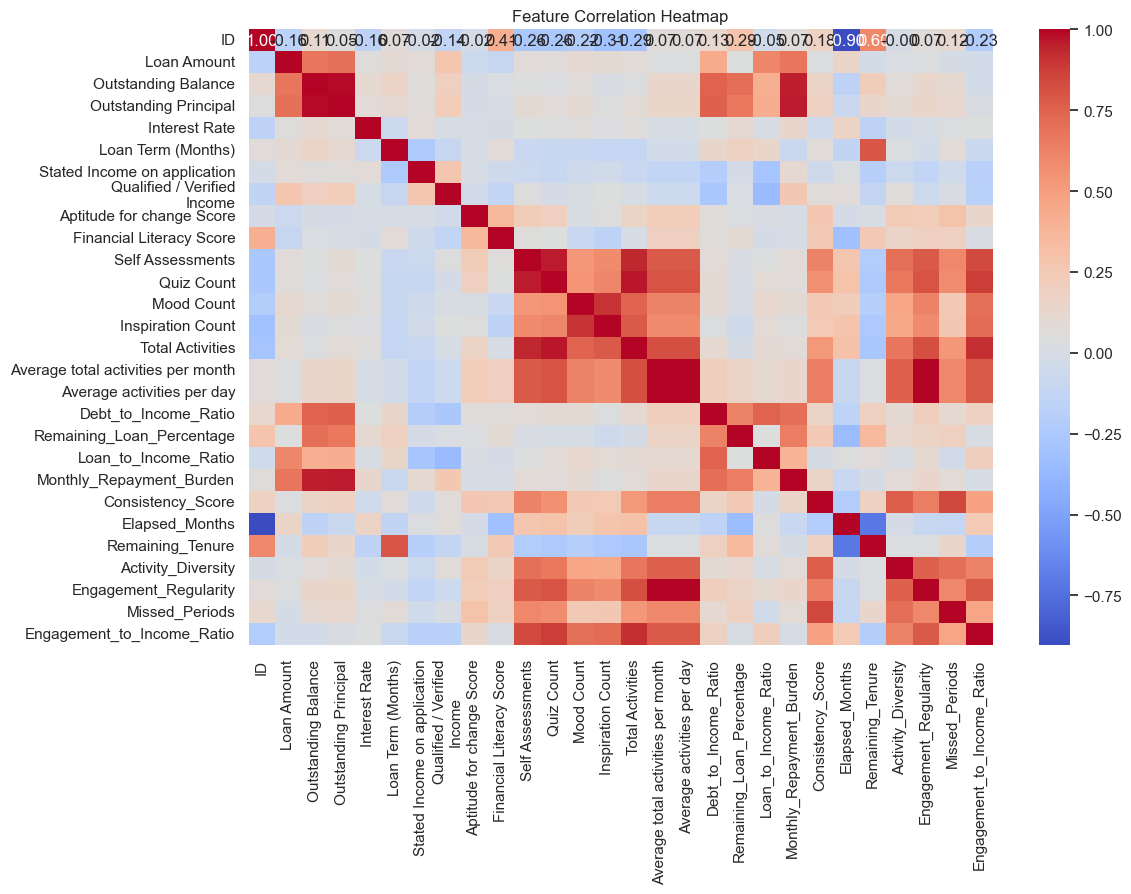

Redundant features (correlation > 0.9): {'Total Activities', 'Outstanding Principal', 'Monthly_Repayment_Burden', 'Engagement_to_Income_Ratio', 'Elapsed_Months', 'Inspiration Count', 'Average activities per day', 'Engagement_Regularity', 'Quiz Count'}
Dropped redundant features.
Silhouette Score for k=4: 0.4745
Silhouette Score for k=5: 0.4466
Silhouette Score for k=6: 0.4348
Silhouette Score for k=7: 0.4012

Optimal number of clusters: 4
Cluster summary saved to 'output/cluster_summary.xlsx'.


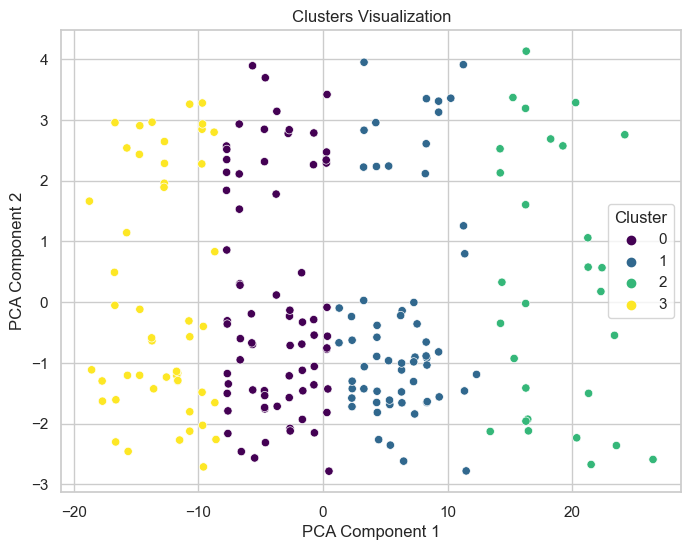

/var/folders/mr/l3x9p9wd385gcyns864s9f2w0000gn/T/ipykernel_97361/374315550.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['revolving_credit_limit', 'instalment_credit_limit']].replace(0, np.nan, inplace=True)


Merged data saved to 'output/merged_data_with_risks.xlsx'.
Engagement model data saved to 'output/engagement_model_data_with_additional_features.xlsx'.
Repayment model data saved to 'output/repayment_model_data.xlsx'.

Training Logistic Regression...

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.79      0.74      0.76       241
           1       0.76      0.81      0.78       246

    accuracy                           0.77       487
   macro avg       0.78      0.77      0.77       487
weighted avg       0.78      0.77      0.77       487

AUC (Logistic Regression): 0.84

Training Random Forest...

Random Forest Report:
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       241
           1       0.82      0.98      0.89       246

    accuracy                           0.88       487
   macro avg       0.90      0.88      0.88       487
weighted avg       0.90      0.88      

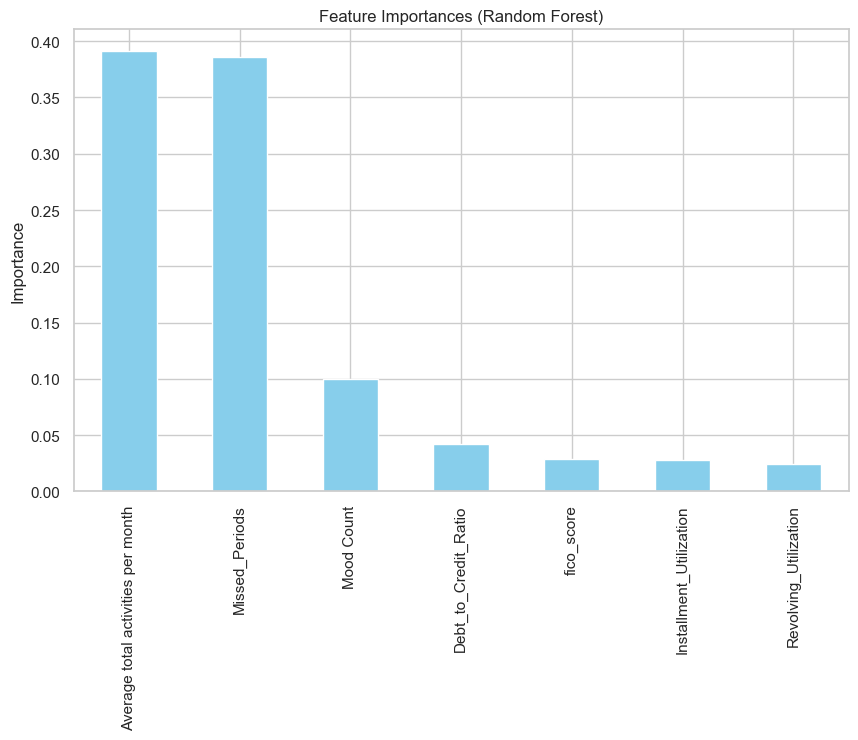

Engagement predictions saved to 'output/engagement_predictions.xlsx'.

Training Logistic Regression for Repayment Risk...

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       288
           1       0.94      0.95      0.95       199

    accuracy                           0.96       487
   macro avg       0.96      0.96      0.96       487
weighted avg       0.96      0.96      0.96       487

AUC (Logistic Regression): 0.98

Training Random Forest for Repayment Risk...

Random Forest Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       288
           1       1.00      0.99      1.00       199

    accuracy                           1.00       487
   macro avg       1.00      1.00      1.00       487
weighted avg       1.00      1.00      1.00       487

AUC (Random Forest): 1.00

Training XGBoost for Repayment Risk...

XGBoost Report:
           

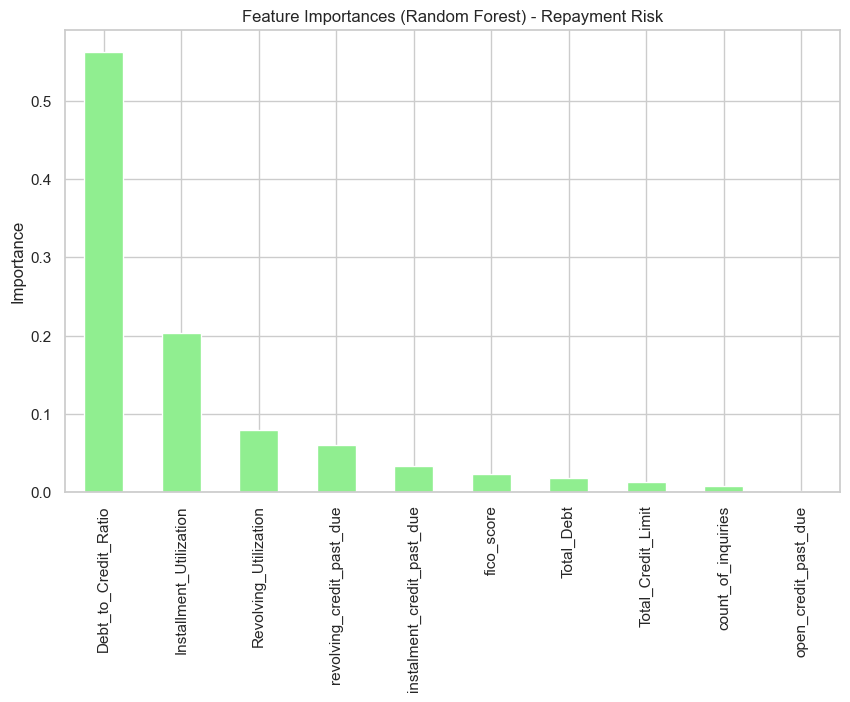

Repayment risk predictions saved to 'output/repayment_predictions.xlsx'.


In [6]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (silhouette_score, classification_report, roc_auc_score,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Set plot style
sns.set(style='whitegrid')

# Constants
OUTPUT_DIR = 'output'
os.makedirs(OUTPUT_DIR, exist_ok=True)
CURRENT_YEAR = datetime.now().year

# Functions

def load_data(file_path, sheet_name):
    """
    Load data from an Excel file and strip whitespace from column names.
    """
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    df.columns = df.columns.str.strip()
    return df

def ensure_column_exists(df, column_name, alternative_names=None):
    """
    Ensure a specific column exists in the DataFrame, possibly under alternative names.
    """
    if column_name in df.columns:
        return column_name
    if alternative_names:
        for alt_name in alternative_names:
            if alt_name in df.columns:
                df.rename(columns={alt_name: column_name}, inplace=True)
                return column_name
    raise ValueError(f"Column '{column_name}' or alternatives {alternative_names} not found.")

def create_financial_features(df):
    """
    Create new financial and engagement features for analysis.
    """
    # Avoid division by zero
    df['Qualified / Verified\nIncome'].replace(0, np.nan, inplace=True)
    df['Loan Term (Months)'].replace(0, np.nan, inplace=True)

    # Financial Ratios
    df['Debt_to_Income_Ratio'] = df['Outstanding Principal'] / df['Qualified / Verified\nIncome']
    df['Remaining_Loan_Percentage'] = df['Outstanding Balance'] / df['Loan Amount']
    df['Loan_to_Income_Ratio'] = df['Loan Amount'] / df['Qualified / Verified\nIncome']
    df['Monthly_Repayment_Burden'] = df['Outstanding Balance'] / df['Loan Term (Months)']

    # Engagement Metrics
    df['Consistency_Score'] = df['Average activities per day'] / df['Average total activities per month']

    # Date Calculations
    df['Date of Birth'] = pd.to_datetime(df['Date of Birth'], errors='coerce')
    df['Age'] = CURRENT_YEAR - df['Date of Birth'].dt.year

    df['Disbursement Date'] = pd.to_datetime(df['Disbursement Date'], errors='coerce')
    df['Elapsed_Months'] = (datetime.now() - df['Disbursement Date']).dt.days // 30
    df['Remaining_Tenure'] = df['Loan Term (Months)'] - df['Elapsed_Months']

    # Activity Diversity
    df['Activity_Diversity'] = df[['Quiz Count', 'Mood Count', 'Inspiration Count']].gt(0).sum(axis=1)

    # Additional Features
    df['Engagement_Regularity'] = df['Consistency_Score'] * df['Average activities per day']
    df['Missed_Periods'] = df['Elapsed_Months'] - (df['Total Activities'] / df['Average total activities per month'])
    df['Engagement_to_Income_Ratio'] = df['Total Activities'] / df['Qualified / Verified\nIncome']

    # Handle infinite and missing values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    return df

def validate_features(df):
    """
    Validate engineered features by analyzing correlations and identifying redundant features.
    """
    # Select numeric columns
    numeric_df = df.select_dtypes(include=['float64', 'int64'])

    # Correlation matrix
    correlation_matrix = numeric_df.corr()

    # Heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Feature Correlation Heatmap")
    plt.show()

    # Identify redundant features
    redundant_features = set()
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    for column in upper_triangle.columns:
        if any(upper_triangle[column].abs() > 0.9):
            redundant_features.add(column)

    print(f"Redundant features (correlation > 0.9): {redundant_features}")
    return redundant_features

def preprocess_data(df, columns_to_remove):
    """
    Preprocess data: remove columns, handle missing values, encode categorical variables, and scale features.
    """
    # Remove unnecessary columns
    df.drop(columns=[col for col in columns_to_remove if col in df.columns], inplace=True)

    # Drop columns with >50% missing values
    df.dropna(thresh=len(df) * 0.5, axis=1, inplace=True)

    # Handle missing values
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    if numeric_cols:
        imputer_num = SimpleImputer(strategy='mean')
        df[numeric_cols] = imputer_num.fit_transform(df[numeric_cols])

    if categorical_cols:
        imputer_cat = SimpleImputer(strategy='most_frequent')
        df[categorical_cols] = imputer_cat.fit_transform(df[categorical_cols])

    # Encode categorical variables
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    # Scale numerical features
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    return df

def perform_pca(df_encoded, variance_threshold=0.85, min_components=2):
    """
    Perform PCA to reduce dimensionality while retaining specified variance.
    """
    pca = PCA(n_components=variance_threshold, random_state=42)
    df_pca = pd.DataFrame(pca.fit_transform(df_encoded))
    if df_pca.shape[1] < min_components:
        pca = PCA(n_components=min_components, random_state=42)
        df_pca = pd.DataFrame(pca.fit_transform(df_encoded))
    return df_pca

def determine_optimal_clusters(df_pca, k_range=range(4, 8)):
    """
    Determine the optimal number of clusters using silhouette scores.
    """
    silhouette_scores = {}
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
        labels = kmeans.fit_predict(df_pca)
        score = silhouette_score(df_pca, labels)
        silhouette_scores[k] = score
        print(f"Silhouette Score for k={k}: {score:.4f}")

    optimal_k = max(silhouette_scores, key=silhouette_scores.get)
    print(f"\nOptimal number of clusters: {optimal_k}")
    return optimal_k

def perform_clustering(df_pca, df_original, optimal_k):
    """
    Perform KMeans clustering and append cluster labels to the original DataFrame.
    """
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
    df_original['Cluster'] = kmeans.fit_predict(df_pca)
    return df_original

def plot_clusters(df_pca, df_original):
    """
    Plot clusters based on the first two principal components.
    """
    if df_pca.shape[1] < 2:
        print("Insufficient PCA components for 2D plot.")
        return
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df_pca.iloc[:, 0], y=df_pca.iloc[:, 1], hue=df_original['Cluster'], palette='viridis')
    plt.title('Clusters Visualization')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.show()

def save_cluster_summary(df_clustered):
    """
    Save cluster summary statistics to an Excel file.
    """
    numeric_cols = df_clustered.select_dtypes(include='number').columns
    cluster_summary = df_clustered.groupby('Cluster')[numeric_cols].mean()
    output_path = os.path.join(OUTPUT_DIR, 'cluster_summary.xlsx')
    cluster_summary.to_excel(output_path)
    print(f"Cluster summary saved to '{output_path}'.")

def merge_transunion_data(df_clustered, trans_union_path, sheet_name='TU - Panel'):
    """
    Merge clustered data with TransUnion data.
    """
    trans_union_data = pd.read_excel(trans_union_path, sheet_name=sheet_name)
    df_clustered['ID'] = df_clustered['ID'].astype(str)
    trans_union_data['loan_id'] = trans_union_data['loan_id'].astype(str)

    merged_data = pd.merge(df_clustered, trans_union_data, left_on='ID', right_on='loan_id', how='left')
    return merged_data

def create_credit_features(df):
    """
    Create additional credit-related features for analysis.
    """
    # Avoid division by zero
    df[['revolving_credit_limit', 'instalment_credit_limit']].replace(0, np.nan, inplace=True)

    df['Total_Debt'] = df['revolving_credit_balance'] + df['instalment_credit_balance']
    df['Total_Credit_Limit'] = df['revolving_credit_limit'] + df['instalment_credit_limit']
    df['Debt_to_Credit_Ratio'] = df['Total_Debt'] / df['Total_Credit_Limit']
    df['Revolving_Utilization'] = df['revolving_credit_balance'] / df['revolving_credit_limit']
    df['Installment_Utilization'] = df['instalment_credit_balance'] / df['instalment_credit_limit']

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    return df

def derive_engagement_and_risk(df):
    """
    Derive 'Engagement_Level' and 'Repayment_Risk' features.
    """
    if 'Consistency_Score' in df.columns:
        median_consistency = df['Consistency_Score'].median()
        df['Engagement_Level'] = (df['Consistency_Score'] >= median_consistency).astype(int)
    else:
        print("Warning: 'Consistency_Score' not found. Cannot derive 'Engagement_Level'.")

    df['Repayment_Risk'] = (
        (df['Debt_to_Credit_Ratio'] > 0.8) |
        (df['revolving_credit_past_due'] > 0) |
        (df['instalment_credit_past_due'] > 0)
    ).astype(int)
    return df

def create_model_datasets(df):
    """
    Create datasets for engagement prediction and loan repayment risk prediction.
    """
    # Engagement Prediction Dataset
    engagement_features = [
        'Mood Count',
        'Average total activities per month',
        'Missed_Periods',
        'fico_score',
        'Revolving_Utilization',
        'Installment_Utilization',
        'Debt_to_Credit_Ratio'
    ]
    engagement_features = [feat for feat in engagement_features if feat in df.columns]

    if 'Engagement_Level' in df.columns:
        engagement_data = df[engagement_features + ['Engagement_Level']]
        output_path = os.path.join(OUTPUT_DIR, 'engagement_model_data_with_additional_features.xlsx')
        engagement_data.to_excel(output_path, index=False)
        print(f"Engagement model data saved to '{output_path}'.")
    else:
        print("Warning: 'Engagement_Level' not found. Engagement model data not created.")

    # Loan Repayment Risk Dataset
    repayment_features = [
        'Debt_to_Credit_Ratio', 'Revolving_Utilization', 'Installment_Utilization',
        'Total_Debt', 'Total_Credit_Limit', 'fico_score', 'count_of_inquiries',
        'revolving_credit_past_due', 'instalment_credit_past_due', 'open_credit_past_due'
    ]
    repayment_features = [feat for feat in repayment_features if feat in df.columns]

    if 'Repayment_Risk' in df.columns:
        repayment_data = df[repayment_features + ['Repayment_Risk']]
        output_path = os.path.join(OUTPUT_DIR, 'repayment_model_data.xlsx')
        repayment_data.to_excel(output_path, index=False)
        print(f"Repayment model data saved to '{output_path}'.")
    else:
        print("Warning: 'Repayment_Risk' not found. Repayment model data not created.")

def clean_data(df):
    """
    Cleans the dataset by replacing infinities and NaN values with the median.
    """
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df.fillna(df.median())

def train_engagement_model():
    """
    Train models to predict engagement levels and evaluate their performance.
    """
    # Load the data
    data_path = os.path.join(OUTPUT_DIR, 'engagement_model_data_with_additional_features.xlsx')
    data = pd.read_excel(data_path)

    # Define features and target
    engagement_features = [
        'Mood Count',
        'Average total activities per month',
        'Missed_Periods',
        'fico_score',
        'Revolving_Utilization',
        'Installment_Utilization',
        'Debt_to_Credit_Ratio'
    ]
    X = data[engagement_features]
    y = data['Engagement_Level']

    # Split the data
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.4, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    # Clean data
    X_train = clean_data(X_train)
    X_val = clean_data(X_val)
    X_test = clean_data(X_test)

    # Train Logistic Regression
    print("\nTraining Logistic Regression...")
    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    print("\nLogistic Regression Report:")
    print(classification_report(y_test, y_pred_lr))
    print(f"AUC (Logistic Regression): {roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1]):.2f}")

    # Train Random Forest
    print("\nTraining Random Forest...")
    rf = RandomForestClassifier(max_depth=5, n_estimators=50, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    print("\nRandom Forest Report:")
    print(classification_report(y_test, y_pred_rf))
    print(f"AUC (Random Forest): {roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]):.2f}")

    # Train XGBoost
    print("\nTraining XGBoost...")
    xgb = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=50, random_state=42, eval_metric='logloss')
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    print("\nXGBoost Report:")
    print(classification_report(y_test, y_pred_xgb))
    print(f"AUC (XGBoost): {roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]):.2f}")

    # Feature importance for Random Forest
    feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    feature_importances.plot(kind='bar', color='skyblue')
    plt.title('Feature Importances (Random Forest)')
    plt.ylabel('Importance')
    plt.show()

    # Save predictions for analysis
    results = pd.DataFrame({
        'Actual': y_test,
        'Logistic Regression': y_pred_lr,
        'Random Forest': y_pred_rf,
        'XGBoost': y_pred_xgb
    })
    predictions_output_path = os.path.join(OUTPUT_DIR, 'engagement_predictions.xlsx')
    results.to_excel(predictions_output_path, index=False)
    print(f"Engagement predictions saved to '{predictions_output_path}'.")

def train_financial_model():
    """
    Train models to predict repayment risk and evaluate their performance, ensuring no data leakage.
    """
    # Load the data
    data_path = os.path.join(OUTPUT_DIR, 'repayment_model_data.xlsx')
    data = pd.read_excel(data_path)

    # Define features and target
    financial_features = [
        'Debt_to_Credit_Ratio', 'Revolving_Utilization', 'Installment_Utilization',
        'Total_Debt', 'Total_Credit_Limit', 'fico_score', 'count_of_inquiries',
        'revolving_credit_past_due', 'instalment_credit_past_due', 'open_credit_past_due'
    ]
    X = data[financial_features]
    y = data['Repayment_Risk']

    # Split the data before any preprocessing to avoid data leakage
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.4, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    # Clean data
    X_train = clean_data(X_train)
    X_val = clean_data(X_val)
    X_test = clean_data(X_test)

    # Feature Scaling (fit only on training data)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Train Logistic Regression
    print("\nTraining Logistic Regression for Repayment Risk...")
    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(X_train_scaled, y_train)
    y_pred_lr = lr.predict(X_test_scaled)
    print("\nLogistic Regression Report:")
    print(classification_report(y_test, y_pred_lr))
    print(f"AUC (Logistic Regression): {roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:, 1]):.2f}")

    # Train Random Forest
    print("\nTraining Random Forest for Repayment Risk...")
    rf = RandomForestClassifier(max_depth=5, n_estimators=50, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    print("\nRandom Forest Report:")
    print(classification_report(y_test, y_pred_rf))
    print(f"AUC (Random Forest): {roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]):.2f}")

    # Train XGBoost
    print("\nTraining XGBoost for Repayment Risk...")
    xgb = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=50, random_state=42, eval_metric='logloss')
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    print("\nXGBoost Report:")
    print(classification_report(y_test, y_pred_xgb))
    print(f"AUC (XGBoost): {roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]):.2f}")

    # Feature importance for Random Forest
    feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    feature_importances.plot(kind='bar', color='lightgreen')
    plt.title('Feature Importances (Random Forest) - Repayment Risk')
    plt.ylabel('Importance')
    plt.show()

    # Save predictions for analysis
    results = pd.DataFrame({
        'Actual': y_test,
        'Logistic Regression': y_pred_lr,
        'Random Forest': y_pred_rf,
        'XGBoost': y_pred_xgb
    })
    predictions_output_path = os.path.join(OUTPUT_DIR, 'repayment_predictions.xlsx')
    results.to_excel(predictions_output_path, index=False)
    print(f"Repayment risk predictions saved to '{predictions_output_path}'.")

# Main Execution

def main():
    file_path = 'Data 3 - October, 2024.xlsx'
    sheet_name = 'Parachute - Cross Section'

    # Load data
    df = load_data(file_path, sheet_name)

    # Ensure 'Total Activities' column exists
    total_activities_col = ensure_column_exists(df, 'Total Activities', alternative_names=['Total Activities '])

    # Create financial and engagement features
    df = create_financial_features(df)

    # Validate features and remove redundant ones
    redundant_features = validate_features(df)
    if redundant_features:
        df.drop(columns=redundant_features, inplace=True)
        print("Dropped redundant features.")

    # Preprocess data
    columns_to_remove = [
        'Disbursement Date', 'Date of Birth', 'ID', 'Gender',
        'Loan Amount', 'Outstanding Balance', 'Outstanding Principal',
        'Loan Term (Months)', 'Stated Income on application',
        'Inspiration Count', 'Average total activities per month',
        'Average activities per day'
    ]
    df_encoded = preprocess_data(df.copy(), columns_to_remove)

    # PCA and clustering
    df_pca = perform_pca(df_encoded)
    optimal_k = determine_optimal_clusters(df_pca)
    df_clustered = perform_clustering(df_pca, df.copy(), optimal_k)

    # Save clustered data and summary
    df_clustered.to_excel(os.path.join(OUTPUT_DIR, 'df_cluster.xlsx'), index=False)
    save_cluster_summary(df_clustered)

    # Visualize clusters
    plot_clusters(df_pca, df_clustered)

    # Merge with TransUnion data
    trans_union_path = 'Data 3 - October, 2024.xlsx'
    merged_data = merge_transunion_data(df_clustered, trans_union_path)

    # Create credit features
    merged_data = create_credit_features(merged_data)

    # Derive engagement level and repayment risk
    merged_data = derive_engagement_and_risk(merged_data)

    # Save merged data
    merged_output_path = os.path.join(OUTPUT_DIR, 'merged_data_with_risks.xlsx')
    merged_data.to_excel(merged_output_path, index=False)
    print(f"Merged data saved to '{merged_output_path}'.")

    # Create datasets for models
    create_model_datasets(merged_data)

    # Train and evaluate the engagement model
    train_engagement_model()

    # Train and evaluate the financial (repayment risk) model
    train_financial_model()

if __name__ == '__main__':
    main()